<div align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens" align="center" /> 
</div>

<br>

---

<div align="center"> 
  <font size="3"><b>Bachelor Thesis</b> </font>
</div>
<br>
<div align="center"> 
  <font size="5">
      <b>WinnER: A Winner-Take-All Hashing-Based Unsupervised Model <br>for Entity Resolution Problems<br></b> 
    </font>
     <hr>
     <font size="4">
        Study on CDDB data set 
    </font>
</div>

---

<div align="center"> 
    <font size="4">
         <b>Konstantinos Nikoletos</b>, BS Student at NKUA 
     </font>
</div>
<div align="center"> 
    <font size="4">
     <b> Alex Delis</b>,  Professor NKUA <br> 
     <b> Vassilios Verykios</b>, Professor Hellenic Open University
    </font>
</div>
<br>
<div align="center"> 
    <font size="2">Athens</font>
</div>
<div align="center"> 
    <font size="2">January 2021 - Ongoing</font>
</div>


---

# __Code injection__

## Import of libraries

In [2]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math
import os
import scipy.special as special
import igraph
import networkx as nx
import itertools 
import sklearn
import plotly.express as px
import logging
import sys
import optuna
import plotly

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming,jaccard
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score
from datetime import datetime
from sklearn.decomposition import PCA 
from numpy.linalg import svd

# plt.style.use('seaborn-white') # plot style

Automated refresh on the notebook

In [3]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Main model dependency

In [4]:
from model import WinnER, customClassificationReport, report

## Utilities

In [5]:
from utils.mmd2 import MMD2, myMMD2
from plot.heatmap import myHeatmap
from plot.confusion_matrix import create_ConfusionMatrix
from plot.dimension_reduction import SpaceVisualization2D, SpaceVisualization3D, SpaceVisualizationEmbeddings2D, SpaceVisualizationEmbeddings3D
from plot.heatmap import similarityProbsHeatMap, similarityProbsHeatMapWithClusters

### Dataset utils

In [6]:
from datasets.common.create_dataset import process_dataset, create_true_labels
from utils.grid_search import GridSearch

### Custom metrics

In [7]:
from utils.metrics import spearman_footrule_distance, kendall_top_k, rbo


# __Dataset injection__

## Load data from Drive in Colab

In [8]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fp = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fp_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

## Load data from disk for Jupyter

In [30]:
CDDB_groundTruth = pd.read_csv(os.path.abspath("../data/cddbIdDuplicates.csv"),sep='/00000',engine='python',header=None,names=['id1','id2'])
CDDB = pd.read_csv(os.path.abspath("../data/cddbProfiles.csv"),sep='/00000',engine='python')
CDDB

Entity Id                               artist    category  \
0             0                           pink floyd        data   
1             1                       Carlos Santana        data   
2             2                          Frans Bauer        data   
3             3                                 2Pac        data   
4             4                                  ̤��        data   
...         ...                                  ...         ...   
9758       9758                              Various  soundtrack   
9759       9759                      James Patterson  soundtrack   
9760       9760      Colin Baker & Nicholas Courtney  soundtrack   
9761       9761                          Studio Cutz  soundtrack   
9762       9762  Audio Adventures In Time & Space/2)  soundtrack   

                                                cdextra       genre  \
0                                             ID3G: 254        Data   
1                                                   NaN         NaN   
2                                                   NaN       Other   
3                                   YEAR: 1998 ID3G: 15         Rap   
4                                                   NaN         NaN   
...                                                 ...         ...   
9758                                                NaN         NaN   
9759                                                NaN  Soundtrack   
9760  Published by Big Finish Productions.\nhttp://w...  Soundtrack   
9761                                           ID3G: 24  Soundtrack   
9762  Published by BBV.\nhttp://www.bbvonline.co.uk/...         NaN   

                             title          track01  \
0                  the wall disc 1     in the flesh   
1                           Carlos    (Da Le) Yaleo   
2                     'n ons geluk     'n ONS geluk   
3              Greatest Hits (CD1)  Keep Ya Head Up   
4                              ̤��          �ȥ�å� 1   
...                            ...              ...   
9758            Warriors of Virtue      You Can Fly   
9759    Pop Goes the Weasel - CD 4             4.01   
9760    The Spectre of Lanyon Moor        Episode 0   
9761                     Volume 25  All Access 3:12   
9762  Prosperity Island (Disk 2/2)       Chapter 15   

                                         track02  \
0                                   the thin ice   
1                                Love Of My Life   
2                                            NaN   
3     2 Of Amerikaz Most Wanted (Ft. Snoop Dogg)   
4                                        �ȥ�å� 2   
...                                          ...   
9758                         A Beautiful Morning   
9759                                        4.02   
9760                            Episode 1 Part 1   
9761                         All Access 3:12 alt   
9762                                  Chapter 16   

                               track03                         track04  ...  \
0     another brick in the wall part 1  the happiest days of our lives  ...   
1               Put You Love Lights On                          Smooth  ...   
2                                  NaN                             NaN  ...   
3                          Temptations              God Bless The Dead  ...   
4                              �ȥ�å� 3                         �ȥ�å� 4  ...   
...                                ...                             ...  ...   
9758                  Forces of Nature                   Inside of You  ...   
9759                              4.03                            4.04  ...   
9760                  Episode 1 Part 2                Episode 1 Part 3  ...   
9761                    All Access :60                  All Access :30  ...   
9762                        Chapter 17                      Chapter 18  ...   

     track92 track93 track94 track95 track96 track97 track98 track99  year  \
0        NaN     NaN   

In [31]:
CDDB.isnull().sum(axis = 0)

Entity Id          0
artist             1
category           0
cdextra         6501
genre           3388
                ... 
track97         9758
track98         9758
track99         9758
year            4533
Unnamed: 106    9763
Length: 107, dtype: int64

In [28]:
na_df = (CDDB.isnull().sum() / len(CDDB)) * 100      
na_df = na_df.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
missing_data.plot(kind = "barh")
plot_width, plot_height = (180, 100)
plt.rcParams['figure.figsize'] = (plot_width,plot_height)
plt.show()

In [9]:
CDDB_groundTruth.sort_values('id1')

id1  id2
176    0  220
27     1  394
148    2    9
64     3  292
182    4  410
..   ...  ...
193  460  466
239  461  469
39   463  464
139  465  470
180  472  476

[299 rows x 2 columns]

# __Dataset attribute analysis__

In [10]:
DATASET_NAME = 'CDDB'

## Data set shuffle (Optional)

In [27]:
CDDB_shuffled = CDDB.sample(frac=1).reset_index(drop=True)
# dataset_shuffled

## Pre-process

In [28]:
fields = list(CDDB.columns)

# All
# data, true_matrix = createDataset(CDDB, CDDB_groundTruth, fields, 'Entity Id')

# Shuffled
data, true_matrix = createDataset(CDDB_shuffled, CDDB_groundTruth, fields, 'Entity Id')

Creating groundtruth matrix: 100%|██████████| 299/299 [00:00<00:00, 7860.56it/s]


__Clique construction for visualization purposes__

In [13]:
labels_groundTruth, numOfObjWithoutDups, groups = createTrueLabels(CDDB['Entity Id'].tolist(), CDDB_groundTruth)            
data_length = [ len(x) for x in data ]

## Attributes

In [14]:
specs = {
    'Objects without any duplicates' : CDDB.shape[0] - sum([len(x) for x in groups]), 
    'Objects with at least one duplicate' : sum([len(x) for x in groups]),
    'Total number of objects' : CDDB.shape[0], 
    'Mean size of clusters' : np.average([len(x) for x in groups]),
    'Number of ER clusters' : len(groups),
    'Dataset size' : len(data), 
    'Average length' : np.mean(data_length), 
    'Min length' : min(data_length), 
    'Max length' : max(data_length),
    'Median length' : np.median(data_length)
}
specsCDDBDf = pd.DataFrame(list(specs.items()), columns=['Spec','#count'])
specsCDDBDf[['#count']] = specsCDDBDf[['#count']].astype(int)
specsCDDBDf

Spec  #count
0       Objects without any duplicates    9287
1  Objects with at least one duplicate     476
2              Total number of objects    9763
3                Mean size of clusters       2
4                Number of ER clusters     221
5                         Dataset size    9763
6                       Average length     326
7                           Min length      23
8                           Max length    4590
9                        Median length     274

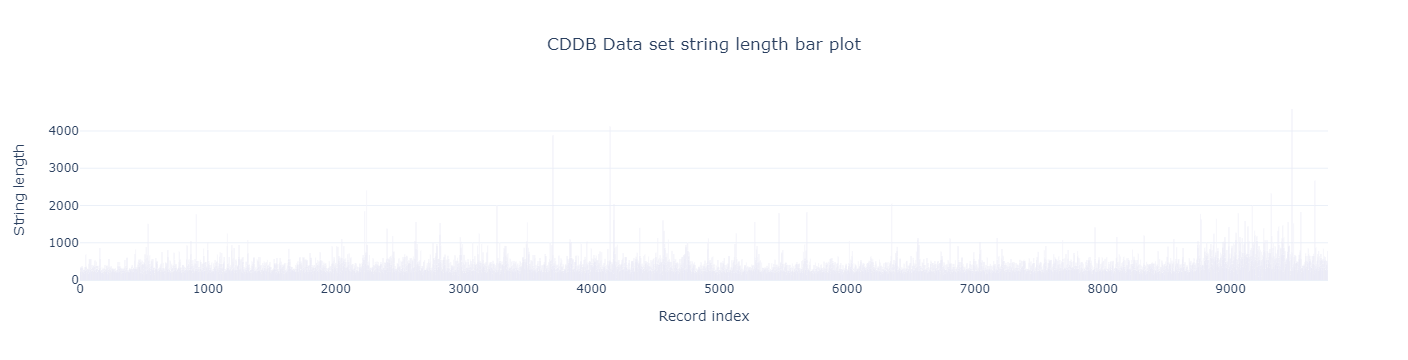

In [15]:
df = pd.DataFrame({"Record index":range(0,len(data_length),1),"String length":data_length})
fig = px.bar(df, x= "Record index", y="String length", title= DATASET_NAME + " Data set string length bar plot",template='plotly_white')
fig.update_traces(marker_color='darkblue', opacity=1.0)
fig.update_layout(title_x=0.5)
fig.show()

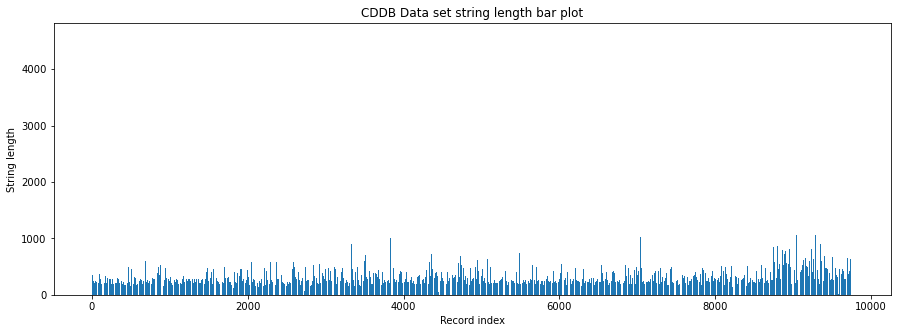

In [16]:
fig = plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title(DATASET_NAME + " Data set string length bar plot")
fig.savefig("strlenncddb.png")
plt.show()


#####################################################################
#                           .~  WinnER  ~.                          #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


Prototype optimization: 100%|██████████| 600/600 [00:17<00:00, 34.77it/s] 


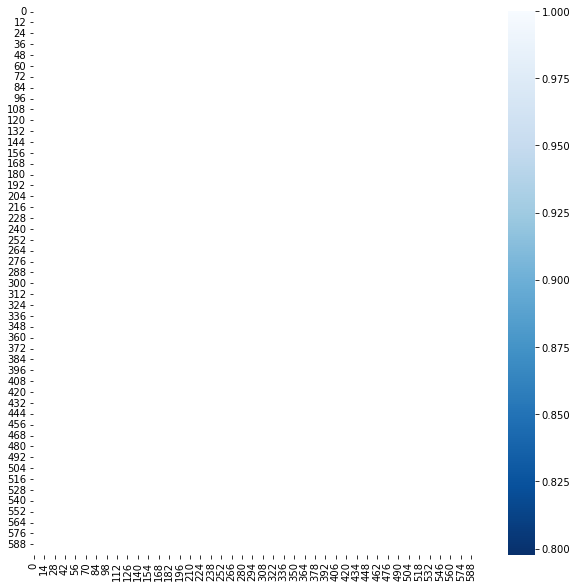


- Mean variance in prototype selection:  0.9597153232263795

- Final number of prototypes:  600

# Finished in 164518 secs


###########################################################
# > 2. Embeddings based on the Vantage objects            #
###########################################################


-> Creating Embeddings:


Creating embeddings: 100%|██████████| 9763/9763 [08:08<00:00, 20.00it/s]


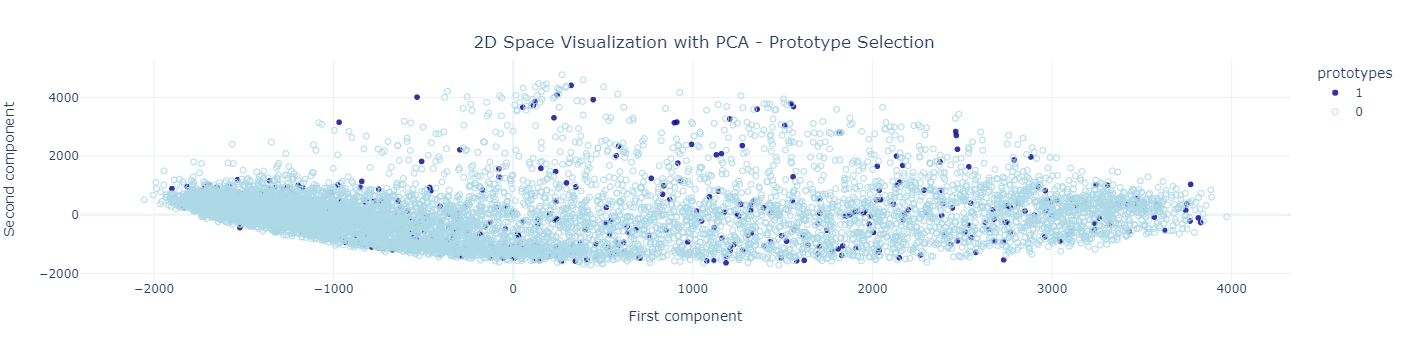


# Finished in 164518 secs


###########################################################
# > 3. WTA Hashing                                        #
###########################################################


-> Creating WTA Buckets:


WTA hashing:   0%|          | 0/1 [00:00<?, ?it/s]


- WTA number of buckets:  10


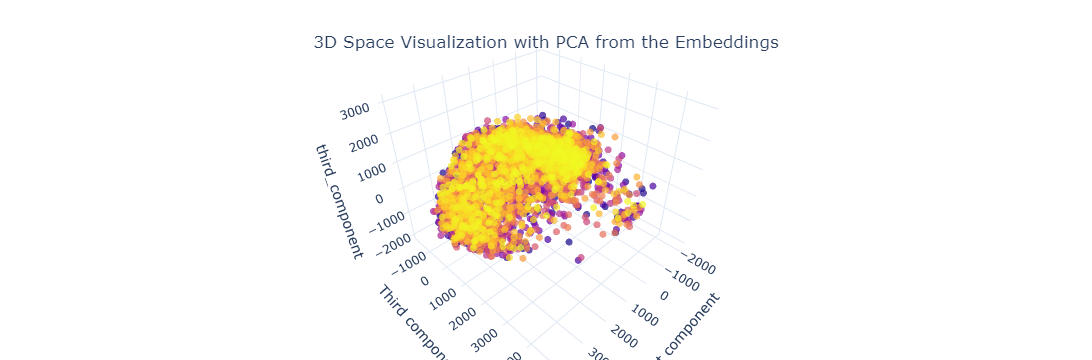


# Finished in 164518 secs


###########################################################
# > 4. Similarity checking                                #
###########################################################


-> Similarity checking:


Similarity checking: 100%|██████████| 10/10 [00:00<00:00, 10034.22it/s]


In [ ]:
winnER = WinnER(
    max_num_of_clusters = 600,
    max_dissimilarity_distance = 0.2,
    window_size = 10,
    similarity_threshold = 0.6,
    metric = "kendal",
    similarity_vectors = "initial",
    number_of_permutations = 1,
    distance_metric = "euclid_jaccard",
    embedding_distance_metric = "euclid_jaccard",
    ngrams = 3,
    char_tokenization = True,
    verbose_level=1
)
winnER.hackForDebug(labels_groundTruth, true_matrix)
winnER.fit(data)
winnER.evaluate(winnER.mapping_matrix, true_matrix)

# Optuna search

## Euclid-Jaccard with 3-grams and char-tokenization

In [ ]:
euclid_jaccard_char_3 = optuna.create_study(
    directions = ["maximize"],
    study_name = "euclid_jaccard_char_3_CDDB", 
    storage    = "sqlite:///optuna_tuning/WinnER_Experiments_v3.db", 
    load_if_exists = True
)

Trials dataframe (Optuna default)

In [ ]:
euclid_jaccard_char_3.trials_dataframe(attrs=("number", "value", "params", "state"))

In [ ]:
plot_optimization_history(euclid_jaccard_char_3)

In [ ]:
# plot_intermediate_values(euclid_jaccard_char_3)

In [ ]:
plot_parallel_coordinate(euclid_jaccard_char_3)

In [ ]:
plot_parallel_coordinate(euclid_jaccard_char_3, params=["number_of_permutations", "similarity_threshold"])

In [ ]:
plot_contour(euclid_jaccard_char_3)

In [ ]:
plot_contour(euclid_jaccard_char_3, params=["number_of_permutations", "similarity_threshold"])

In [ ]:
plot_slice(euclid_jaccard_char_3,  params=["number_of_permutations", "similarity_threshold", "max_dissimilarity_distance", "window_size", "max_num_of_clusters"])

In [ ]:
plot_param_importances(euclid_jaccard_char_3)

In [ ]:
plot_edf(euclid_jaccard_char_3)

In [ ]:
optuna.visualization.plot_param_importances(
    euclid_jaccard_char_3, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

### Study statistics

In [ ]:
euclid_jaccard_char_3_DF = pd.read_csv(
    os.path.abspath("./optuna_tuning/csv/euclid_jaccard_char_3_CDDB.csv")
)
print(euclid_jaccard_char_3_DF.columns)

In [ ]:
ltable = euclid_jaccard_char_3_DF[['trial_id','Recall','F1','Precision','Accuracy', 'Time']].sort_values(by=['F1','Recall','F1'], ascending=False).head(10)
ltable = ltable.sort_values(by=['Recall','F1'], ascending=False)
ltable['Time'] = ltable['Time'].astype('datetime64[s]').dt.strftime("%M:%S")
print(ltable.to_latex(index=False))



In [ ]:
fig = px.parallel_coordinates(
    euclid_jaccard_char_3_DF[[ 'diffObjectsComparedSuccess',
       'sameObjectsCompared', 'sameObjectsComparedSuccess', 'selectedNumOfPrototypes', 'number_of_permutations', 'num_of_comparisons', 'Recall']], color="Recall", 
    # labels={"num_of_comparisons": "num_of_comparisons", "diffObjectsComparedSuccess": "diffObjectsComparedSuccess"},
    color_continuous_scale=px.colors.sequential.RdBu, 
    color_continuous_midpoint=2
)
fig.show()

In [ ]:
fig = px.parallel_coordinates(
    euclid_jaccard_char_3_DF[[ 'max_dissimilarity_distance', 'max_num_of_clusters', 'selectedNumOfPrototypes', 'Recall', 'Accuracy']], color="Recall", 
    # labels={"num_of_comparisons": "num_of_comparisons", "diffObjectsComparedSuccess": "diffObjectsComparedSuccess"},
    color_continuous_scale=px.colors.sequential.RdBu, 
    # color_continuous_midpoint=2
)
fig.show()

In [ ]:
# fig = px.parallel_categories(
#     euclid_jaccard_char_3_DF[[ 'diffObjectsComparedSuccess', 'sameObjectsCompared', 'sameObjectsComparedSuccess', 'selectedNumOfPrototypes', 'number_of_permutations', 'num_of_comparisons', 'Recall', 'trial_id']], 
#     color="Recall",
#     color_continuous_scale=px.colors.sequential.Inferno
# )
# fig.show()

In [ ]:
fig = px.scatter(
    euclid_jaccard_char_3_DF[['F1', 'Time', 'diffObjectsComparedSuccess', 'sameObjectsCompared', 'sameObjectsComparedSuccess', 'selectedNumOfPrototypes', 'number_of_permutations', 'num_of_comparisons', 'Recall', 'trial_id']], 
    x="diffObjectsComparedSuccess", 
    y="sameObjectsComparedSuccess", 
    size="num_of_comparisons", 
    color="Recall",
    # hover_name="F1", 
    log_x=True, 
    color_continuous_scale=px.colors.sequential.RdBu_r, 
    size_max=10,
    template='plotly_white',
    labels={
         "diffObjectsComparedSuccess": "Different papers compared with success",
         "sameObjectsComparedSuccess": "Same papers compared with success",
     }
)
fig.show()

In [ ]:
plot_df = euclid_jaccard_char_3_DF[['F1', 'Time', 'diffObjectsComparedSuccess', 'sameObjectsCompared', 'sameObjectsComparedSuccess', 'selectedNumOfPrototypes', 'number_of_permutations', 'num_of_comparisons', 'Recall', 'trial_id']].sort_values('Recall', ascending=True).tail(10)

px.scatter(
    plot_df, 
    x="diffObjectsComparedSuccess", 
    y="sameObjectsComparedSuccess", 
    # size="num_of_comparisons", 
    # color="Time",
    # hover_name="F1", 
    animation_frame="Recall", 
    animation_group="number_of_permutations",
    # facet_col="Recall",
    log_x=True, 
    template='plotly_white'
    # size_max=10, 
    # range_x=[1000,10000000], 
    # range_y=[10,100]
)
# fig.show()

In [ ]:
fig = px.parallel_coordinates(
    euclid_jaccard_char_3_DF[[ 'window_size', 'number_of_permutations', 'averageBucketSize','similarityTime', 'Recall', 'Accuracy']], color="Recall", 
    # labels={"num_of_comparisons": "num_of_comparisons", "diffObjectsComparedSuccess": "diffObjectsComparedSuccess"},
    color_continuous_scale=px.colors.sequential.RdBu, 
    # color_continuous_midpoint=2
)
fig.show()

### Best model

In [ ]:
# euclid_jaccard_char_3.best_trial.number
# euclid_jaccard_char_3_DF[]
best_params = euclid_jaccard_char_3_DF[euclid_jaccard_char_3_DF['trial_id'] == 12].to_dict('records')[0]

In [ ]:
best_params

In [ ]:
winnER = WinnER(verbose_level=1)
winnER.set_params(best_params)
winnER.hackForDebug(labels_groundTruth, true_matrix)
winnER.fit(data)
winnER.evaluate(winnER.mapping_matrix, true_matrix)

### Space Visualization

In [ ]:
SpaceVisualization2D(winnER.Embeddings, winnER.prototypeArray)

In [ ]:
SpaceVisualization2D(winnER.Embeddings, winnER.prototypeArray, decompositionMenthod='MDS')

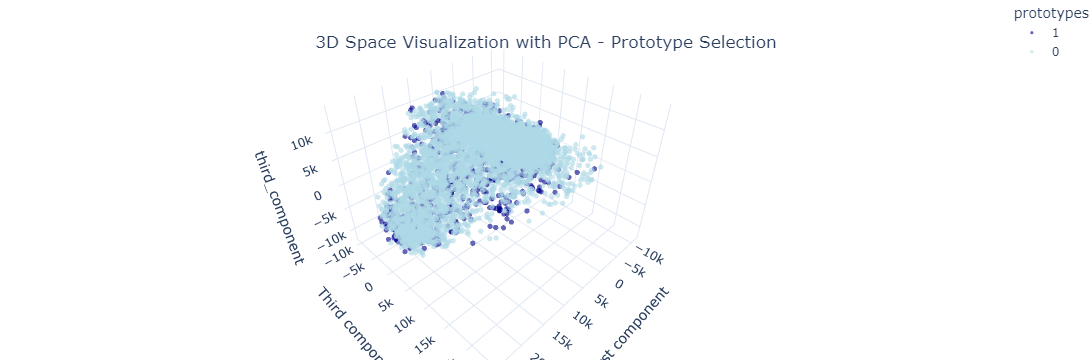

In [25]:
SpaceVisualization3D(winnER.Embeddings, winnER.prototypeArray)

In [ ]:
SpaceVisualization3D(winnER.rankedVectors,winnER.prototypeArray, decompositionMenthod='MDS')

In [ ]:
SpaceVisualization3D(winnER.rankedVectors, winnER.prototypeArray, withPlotly = True, decompositionMenthod='MDS')

In [ ]:
SpaceVisualizationEmbeddings2D(
    winnER.Embeddings, labels_groundTruth, withPlotly=True, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    winnER.rankedVectors, labels_groundTruth, withPlotly=True, decompositionMenthod='PCA'
)

In [ ]:
SpaceVisualizationEmbeddings3D(
    winnER.rankedVectors, labels_groundTruth, withPlotly=True, decompositionMenthod='MDS'
)

__MMD error between distribution of Prototypes and whole Dataset__

In [ ]:
myMMD2(winnER)